## Öffnen von LIF-Dateien

Bei der Arbeit mit mikroskopischen Bilddaten sind viele Dateiformate im Umlauf, wie zum Beispiel das Leica Image Format (LIF). In diesem Notebook werden wir eine `.lif`-Datei mit Hilfe der [`readlif` Bibliothek](https://pypi.org/project/readlif/) öffnen.

Hinweis: Es wird empfohlen, [AICSImageIO](https://github.com/AllenCellModeling/aicsimageio) zum Lesen von LIF-Bildern zu verwenden, wie in diesem [Notebook](image_file_formats:aicsimagio) gezeigt.

Die `readlif` Bibliothek kann wie folgt über das Terminal installiert werden:

```
pip install readlif
```

Nach der Installation kann sie importiert werden.

In [1]:
from readlif.reader import LifFile

import os
import requests
from skimage.io import imshow
import numpy as np

Als Beispieldatensatz verwenden wir ein Bild, das von [Gregory Marquart und Harold Burgess](https://zenodo.org/record/3382102#.Y57rFnbMJaQ) unter der [CC-BY 4.0 Lizenz](https://creativecommons.org/licenses/by/4.0/legalcode) geteilt wurde. Wir müssen es zuerst herunterladen.

In [2]:
filename = "../../data/y293-Gal4_vmat-GFP-f01.lif"
url = 'https://zenodo.org/record/3382102/files/y293-Gal4_vmat-GFP-f01.lif?download=1'

if not os.path.isfile(filename):
    # die Datei nur herunterladen, wenn wir sie noch nicht haben
    response = requests.get(url)
    open(filename, "wb").write(response.content)

An diesem Punkt sollte die Datei auf unserem Computer sein und kann wie folgt geöffnet werden.

In [3]:
file = LifFile(filename)
file

'LifFile object with 1 image'

In [4]:
lif_image = file.get_image(0)
lif_image

'LifImage object with dimensions: Dims(x=616, y=500, z=86, t=1, m=1)'

Aus dem LifImage können wir einzelne Frames als [PIL](https://pypi.org/project/PIL/) Bilder erhalten.

In [5]:
pil_image = lif_image.get_frame(z=0)
type(pil_image)

PIL.Image.Image

Schließlich können diese 2D PIL-Bilder in numpy-Arrays umgewandelt werden. Das ermöglicht es uns letztendlich, einen Blick auf das Bild zu werfen.

In [6]:
np_image = np.array(pil_image)
np_image.shape

(500, 616)

/opt/miniconda3/envs/devbio-napari-env/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


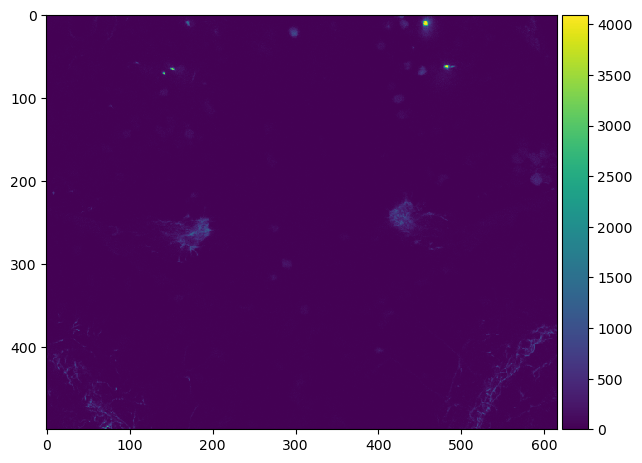

In [7]:
imshow(np_image)

Um auf alle Pixel in unserem 3D-Bild zuzugreifen, sollten wir zunächst einen Blick in die Metadaten der Datei werfen.

In [8]:
lif_image.info

{'dims': Dims(x=616, y=500, z=86, t=1, m=1),
 'display_dims': (1, 2),
 'dims_n': {1: 616, 2: 500, 3: 86},
 'scale_n': {1: 2.1354804344851965,
  2: 2.135480168493237,
  3: 0.9929687300128537},
 'path': 'Experiment_002/',
 'name': 'Series011',
 'channels': 2,
 'scale': (2.1354804344851965, 2.135480168493237, 0.9929687300128537, None),
 'bit_depth': (12, 12),
 'mosaic_position': [],
 'channel_as_second_dim': False,
 'settings': {}}

Zum Beispiel könnte es später nützlich sein, die Voxelgröße in z/y/x-Reihenfolge zu kennen.

In [9]:
voxel_size = lif_image.info['scale'][2::-1]
voxel_size

(0.9929687300128537, 2.135480168493237, 2.1354804344851965)

Wir können auch auslesen, wie viele Schichten der 3D-Stapel hat.

In [10]:
num_slices = lif_image.info['dims'].z
num_slices

86

Diese Information ermöglicht es uns, eine Hilfsfunktion zu schreiben, die das LIF-Bild in einen 3D-numpy-Bildstapel umwandelt.

In [11]:
def lif_to_numpy_stack(lif_image):
    num_slices = lif_image.info['dims'].z
    
    return np.asarray([np.array(lif_image.get_frame(z=z)) for z in range(num_slices)])

In [12]:
image_stack = lif_to_numpy_stack(lif_image)
image_stack.shape

(86, 500, 616)

Dieser Bildstapel kann dann beispielsweise verwendet werden, um eine Maximumintensitätsprojektion entlang Z zu visualisieren.

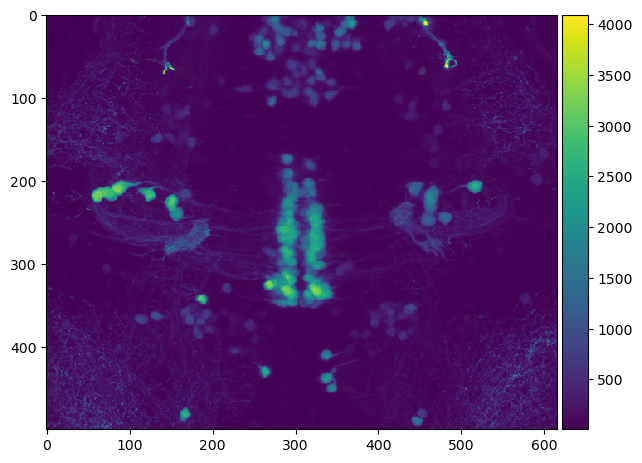

In [13]:
imshow(np.max(image_stack, axis=0))